#Transfer leaning with Tensorflow part 1: Feature Extraction

Transfer learning is leveraging working model's existing architecture and learned patterns for our own problems.

There are two main benifits:
1. Can leverage existing neural network architecture proven to work on problems similar to our own
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own then we can adopt those patterns to our own data

###Downloading and getting one with data


In [1]:
#Get the data 10% of data
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#unzip the file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2025-01-25 07:24:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   229MB/s    in 0.7s    

2025-01-25 07:24:47 (229 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
#How many images in each folders
import os

#Walk through 10% data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")


There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/train
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings
There are 10 director

Cretaing data loders(prepparing the data).

We are using Imagedatagenerator class to load in our images in batches

In [3]:
#Setupdata inputs
from tf_keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE =32

train_dir = "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

print("Training Images")
train_data_10_percent = train_datagen.flow_from_directory(
    train_dir, target_size = IMAGE_SHAPE,
    batch_size = BATCH_SIZE,
    class_mode = "categorical"
)

print("Testing images:")
test_data_10_percent = test_datagen.flow_from_directory(
    test_dir,
    target_size = IMAGE_SHAPE,
    batch_size = BATCH_SIZE,
    class_mode = "categorical"
)



Training Images
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


##Seting up callbacks (things to run whilst our model trains)

Callbacks extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:
* Tracking experiment with the TensorBoard callback
* Model checkpointing with the modelcheckpoint callback
* Stopping a model from training (before it trains too long and overfit) with earlystopping callback



In [4]:
#create tensorboard callback (functionaized because we need to create a new one for each)

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name+ '/'+ experiment_name + '/'+ datetime.datetime.now().strftime("%y%m%d-%H%M%S")
  tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving Tensorboard log files to: {log_dir}")
  return tensorboard_callback



##Create model using tensorflow hub

In the past we've used Tensorflow to create our own models layer by layer from scratch.

We are going to do a similar process, except the majority of our model's layers are going to come from Tensorflowhub.

We can access pretrained models on : tfhub.dev

Browsing the tensorflow hub page and sorting for image classification, we can found vector feature

In [5]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url ="https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1"

In [6]:
#Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras as keras
from tf_keras import layers

In [7]:
#Let's make a create model function to create a model from a url
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model

### Creating and testing resnet feature extraction model


In [8]:
#Create resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)


In [9]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [10]:
#Compile our resnet model
resnet_model.compile(
    loss ="categorical_crossentropy",
    optimizer = keras.optimizers.Adam(),
    metrics = ["accuracy"]

)

In [11]:
#Let's fit our resnet model to our data(10 percent of 10 classes)

resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])


Saving Tensorboard log files to: tensorflow_hub/resnet50V2/250125-072514
Epoch 1/5
24/24 [==============================] - 25s 637ms/step - loss: 1.9160 - accuracy: 0.3507 - val_loss: 1.1771 - val_accuracy: 0.6184
Epoch 2/5
24/24 [==============================] - 11s 453ms/step - loss: 0.8721 - accuracy: 0.7520 - val_loss: 0.8325 - val_accuracy: 0.7364
Epoch 3/5
24/24 [==============================] - 11s 487ms/step - loss: 0.6022 - accuracy: 0.8307 - val_loss: 0.7488 - val_accuracy: 0.7552
Epoch 4/5
24/24 [==============================] - 13s 542ms/step - loss: 0.4642 - accuracy: 0.8933 - val_loss: 0.7047 - val_accuracy: 0.7564
Epoch 5/5
24/24 [==============================] - 15s 661ms/step - loss: 0.3669 - accuracy: 0.9227 - val_loss: 0.6578 - val_accuracy: 0.7832


our transfer learning feature extractor model out performed all of the previous model we built by hand

In [12]:
#Let's create a function to plot our loss curves
#Tidbit: you could put a function like this in to script called "helper.py" and import it when needed

import matplotlib.pyplot as plt

#plot the validation and training curve
def plot_loss_curves(history):
  """Returns seperate loss curves for training and validation metrics

  Args:
    history: Tensorflow History object
  returns:
    plots of training/validation loss and accuracy metrics
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label ="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy,label ="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

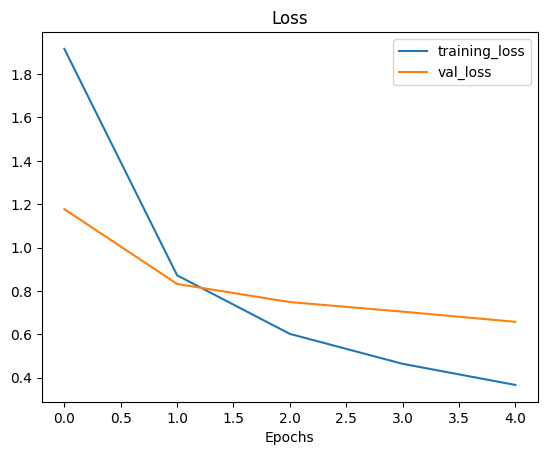

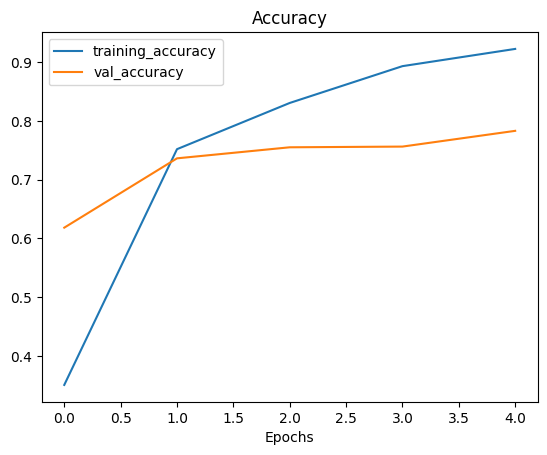

In [13]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 Tensorflow Hub feature Extraction model

In [14]:
#Build effcientnetB0 feature extraction
efficient_model = create_model(model_url=efficientnet_url,
                              num_classes=train_data_10_percent.num_classes)

#Compile efficient net model
efficient_model.compile(
    loss = "categorical_crossentropy",
    optimizer = keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

#Fit efficient model to 10% of training data
efficient_history = efficient_model.fit(
    train_data_10_percent,
    epochs =5,
    validation_data = test_data_10_percent,
    validation_steps = len(test_data_10_percent),
    steps_per_epoch=len(train_data_10_percent),
    callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub",
                                             experiment_name = "efficientnetb0")]

)

Saving Tensorboard log files to: tensorflow_hub/efficientnetb0/250125-072642
Epoch 1/5
24/24 [==============================] - 27s 625ms/step - loss: 1.8574 - accuracy: 0.4360 - val_loss: 1.3067 - val_accuracy: 0.7260
Epoch 2/5
24/24 [==============================] - 10s 423ms/step - loss: 1.0839 - accuracy: 0.7600 - val_loss: 0.8678 - val_accuracy: 0.8196
Epoch 3/5
24/24 [==============================] - 9s 402ms/step - loss: 0.7608 - accuracy: 0.8347 - val_loss: 0.6969 - val_accuracy: 0.8456
Epoch 4/5
24/24 [==============================] - 10s 422ms/step - loss: 0.6090 - accuracy: 0.8747 - val_loss: 0.6078 - val_accuracy: 0.8592
Epoch 5/5
24/24 [==============================] - 10s 430ms/step - loss: 0.5156 - accuracy: 0.8947 - val_loss: 0.5524 - val_accuracy: 0.8656


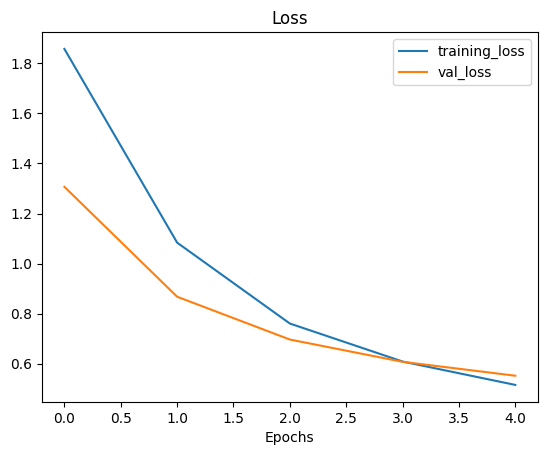

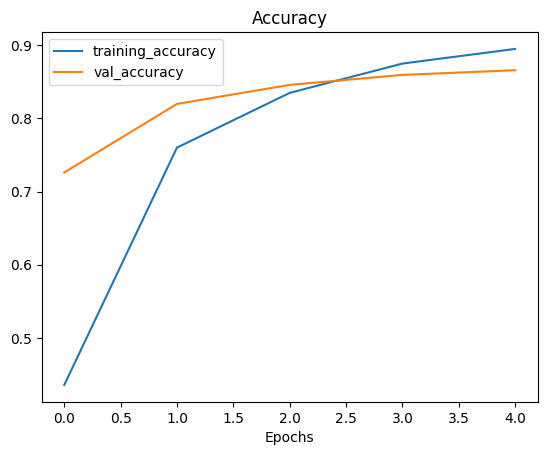

In [15]:
plot_loss_curves(efficient_history)

In [16]:
efficient_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [20]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [19]:
#How many layers does our efficientnetb0 feature extractor have?
len(efficient_model.layers[0].weights)

309